<a href="https://colab.research.google.com/github/Akshita-jpg/pyspark-recommender-system/blob/main/PySpark_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
#import libraries and create pyspark session
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Create Spark Session
spark = SparkSession.builder \
    .appName("MovieRecommender") \
    .getOrCreate()

print("Spark Version:", spark.version)

Spark Version: 4.0.2


In [ ]:
#Load movieLens dataset
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2026-02-21 07:08:37--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K  1.63MB/s    in 0.6s    

2026-02-21 07:08:39 (1.63 MB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Load ratings
ratings = spark.read.csv(
    "ml-latest-small/ratings.csv",
    header=True,
    inferSchema=True
)

ratings = ratings.select("userId", "movieId", "rating")
ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows


In [ ]:
#Train-Test-Split
(training, test) = ratings.randomSplit([0.8, 0.2])

In [ ]:
#Build ALS model
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    maxIter=10,
    regParam=0.1,
    rank=10
)

model = als.fit(training)

In [ ]:
#Make predictions
predictions = model.transform(test)
predictions.show(5)

In [ ]:
#Evaluate Model using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.8764123519420075


**Generate Recommendations**

In [ ]:
#Top 5 Movies for each user
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5, truncate=False)

+------+---------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                    |
+------+---------------------------------------------------------------------------------------------------+
|1     |[{3200, 5.729713}, {33649, 5.723707}, {68945, 5.6146345}, {5915, 5.5769243}, {132333, 5.5519056}]  |
|2     |[{167746, 5.149389}, {7669, 5.1262717}, {131724, 4.8800783}, {33649, 4.8427544}, {25771, 4.817178}]|
|3     |[{70946, 5.2373834}, {86320, 5.02857}, {6835, 4.9630914}, {5746, 4.9630914}, {5181, 4.878837}]     |
|4     |[{26865, 5.199774}, {7700, 5.076826}, {28, 4.943669}, {166534, 4.9266806}, {3851, 4.923962}]       |
|5     |[{132333, 4.931482}, {5490, 4.931482}, {5915, 4.8817225}, {3200, 4.8572874}, {1262, 4.7861543}]    |
+------+---------------------------------------------------------------------------------------------------+
only showing top 5 

In [21]:
#Top 5 Users for each movie
movie_recommendations = model.recommendForAllItems(5)
movie_recommendations.show(5, truncate=False)

+-------+---------------------------------------------------------------------------------------+
|movieId|recommendations                                                                        |
+-------+---------------------------------------------------------------------------------------+
|1      |[{43, 5.0337}, {53, 4.9987993}, {138, 4.9528103}, {543, 4.7913475}, {93, 4.661673}]    |
|3      |[{12, 4.416362}, {43, 4.3040366}, {243, 4.2540145}, {543, 4.244974}, {53, 4.20641}]    |
|5      |[{543, 4.273119}, {594, 4.216923}, {43, 4.133005}, {584, 4.092428}, {554, 3.8255749}]  |
|6      |[{53, 5.270483}, {360, 4.9922743}, {452, 4.8670907}, {276, 4.8518076}, {236, 4.740115}]|
|9      |[{543, 4.6512303}, {492, 4.374812}, {240, 4.3104835}, {43, 4.1735663}, {53, 4.171844}] |
+-------+---------------------------------------------------------------------------------------+
only showing top 5 rows


In [23]:
#Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10]) \
    .addGrid(als.regParam, [0.01, 0.1]) \
    .build()

crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = crossval.fit(training)

In [24]:
#Extract Best model
best_model = cv_model.bestModel

print("Best Rank:", best_model.rank)
print("Best Regularization:", best_model._java_obj.parent().getRegParam())

Best Rank: 5
Best Regularization: 0.1


In [25]:
#Re-evaluate Best model
best_predictions = best_model.transform(test)

rmse = evaluator.evaluate(best_predictions)
print("Final Tuned RMSE:", rmse)

Final Tuned RMSE: 0.8786881162433364


In [26]:
#Load movies dataset
movies = spark.read.csv(
    "ml-latest-small/movies.csv",
    header=True,
    inferSchema=True
)

movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows


In [27]:
#recommendations
user_id = 10

user_subset = ratings.filter(ratings.userId == user_id)

recommendations = best_model.recommendForUserSubset(
    user_subset.select("userId").distinct(), 5
)

recommendations.show(truncate=False)

+------+----------------------------------------------------------------------------------------------+
|userId|recommendations                                                                               |
+------+----------------------------------------------------------------------------------------------+
|10    |[{49347, 5.226933}, {3925, 4.9277687}, {7018, 4.919547}, {44974, 4.8907266}, {5668, 4.847317}]|
+------+----------------------------------------------------------------------------------------------+



In [28]:
#Explode recommendation
from pyspark.sql.functions import explode

rec_exploded = recommendations.select(
    "userId",
    explode("recommendations").alias("rec")
).select(
    "userId",
    "rec.movieId",
    "rec.rating"
)

final_recs = rec_exploded.join(movies, "movieId")
final_recs.show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  49347|    10| 5.226933|Fast Food Nation ...|               Drama|
|   3925|    10|4.9277687|Stranger Than Par...|        Comedy|Drama|
|   7018|    10| 4.919547|Presumed Innocent...|Crime|Drama|Thriller|
|  44974|    10|4.8907266|   Hard Candy (2005)|      Drama|Thriller|
|   5668|    10| 4.847317|White Oleander (2...|               Drama|
+-------+------+---------+--------------------+--------------------+



In [29]:
best_model.save("ALS_Recommender_Model")

In [30]:
#Feature engineering
ratings.groupBy("userId").count().show()

+------+-----+
|userId|count|
+------+-----+
|   148|   48|
|   463|   33|
|   471|   28|
|   496|   29|
|   243|   36|
|   392|   25|
|   540|   42|
|    31|   50|
|   516|   26|
|    85|   34|
|   137|  141|
|   251|   23|
|   451|   34|
|   580|  436|
|    65|   34|
|   458|   59|
|    53|   20|
|   255|   44|
|   481|   31|
|   588|   56|
+------+-----+
only showing top 20 rows


In [31]:
#Cold start problem
coldStartStrategy="drop"

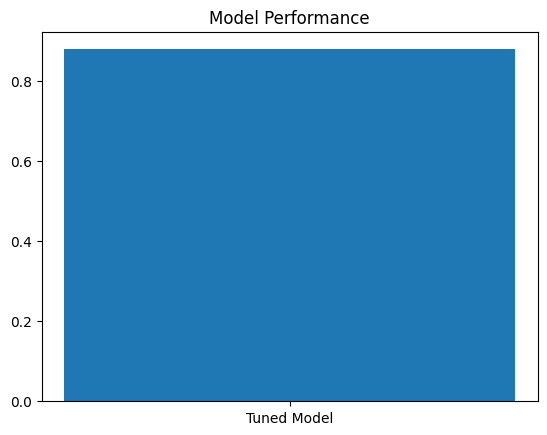

In [32]:
#Visualisation
import matplotlib.pyplot as plt

rmse_values = [rmse]  # Example
plt.bar(["Tuned Model"], rmse_values)
plt.title("Model Performance")
plt.show()